## Silvana Ortiz Rodriguez 

### 002 Introduction to Trading
#### Ya se que este jupyter no lo vas a ver pero por si acaso

#### Librerias

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import optuna
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

sns.set_theme()

In [198]:
DATA_PATH = '/Users/silvanaortizrodriguez/Desktop/ITESO/11vo Semestre/Trading/Binance_BTCUSDT_1h.csv'

In [199]:
data = pd.read_csv(DATA_PATH, skiprows=1).copy()

#### Acomodo de las columnas del csv

In [200]:
data = data.iloc[:, :10]
data.columns = [
    'Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
    'Volume BTC', 'Volume USDT', 'tradecount'
]

# Parse Date as datetime and set as index
data['Date'] = pd.to_datetime(data['Date'], format='mixed')
data = data.set_index('Date').sort_index()

# Ensure numeric Close
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Drop rows with NaNs in Close
data = data.dropna(subset=['Close'])



#### Primer Backtesting 
#### Antes de cambiar variables, ajustar parametros, solo con posición larga.

In [201]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=15)
data['rsi'] = rsi_indicator.rsi()

# MACD
macd = ta.trend.MACD(close=data['Close'])
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()
data['macd_hist'] = macd.macd_diff()

# Bollinger Bands
bb = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['bb_high'] = bb.bollinger_hband()
data['bb_low'] = bb.bollinger_lband()
data['bb_mid'] = bb.bollinger_mavg()


# Individual signals
data['rsi_buy'] = data['rsi'] < 30
data['rsi_sell'] = data['rsi'] > 70

data['macd_buy'] = data['macd_hist'] > 0
data['macd_sell'] = data['macd_hist'] < 0

data['bb_buy'] = data['Close'] < data['bb_low']
data['bb_sell'] = data['Close'] > data['bb_high']

# Signal confirmation: 2 out of 3 agree
data['buy_signal'] = (data[['rsi_buy', 'macd_buy', 'bb_buy']].sum(axis=1) >= 2)
data['sell_signal'] = (data[['rsi_sell', 'macd_sell', 'bb_sell']].sum(axis=1) >= 2)

data = data.dropna()

from dataclasses import dataclass
@dataclass
class Position:
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str
    position_type: str  # 'long' or 'short'


COM = 0.125 / 100       # 0.125% commission
stop_loss = 0.05        # 5% stop loss
take_profit = 0.05      # 5% take profit
n_shares = 50
cash = 1_000_000
active_positions: list[Position] = []
portfolio_value = []

for i, row in data.iterrows():
    # Check open positions
    for position in active_positions[:]:
        if position.position_type == 'long':
            if row['Close'] >= position.tp or row['Close'] <= position.sl:
                cash += row['Close'] * position.n_shares * (1 - COM)
                active_positions.remove(position)
        elif position.position_type == 'short':
            if row['Close'] <= position.tp or row['Close'] >= position.sl:
                cash += (2 * position.price - row['Close']) * position.n_shares * (1 - COM)
                active_positions.remove(position)

    # Open new positions
    if row['buy_signal'] and all(p.position_type != 'long' for p in active_positions):
        cost = row['Close'] * n_shares * (1 + COM)
        if cash >= cost:
            cash -= cost
            pos = Position(
                ticker='BTCUSDT',
                n_shares=n_shares,
                price=row['Close'],
                sl=row['Close'] * (1 - stop_loss),
                tp=row['Close'] * (1 + take_profit),
                time=i,  # Use the index as the date/time
                position_type='long'
            )
            active_positions.append(pos)

    elif row['sell_signal'] and all(p.position_type != 'short' for p in active_positions):
        cost = row['Close'] * n_shares * (1 + COM)
        if cash >= cost:
            cash -= cost
            pos = Position(
                ticker='BTCUSDT',
                n_shares=n_shares,
                price=row['Close'],
                sl=row['Close'] * (1 + stop_loss),
                tp=row['Close'] * (1 - take_profit),
                time=i,  # Use the index as the date/time
                position_type='short'
            )
            active_positions.append(pos)

    # Portfolio value
    invested = sum(p.price * n_shares for p in active_positions)
    portfolio_value.append(cash + invested)

# Close remaining positions
for position in active_positions:
    if position.position_type == 'long':
        cash += data['Close'].iloc[-1] * n_shares * (1 - COM)
    elif position.position_type == 'short':
        cash += (2 * position.price - data['Close'].iloc[-1]) * n_shares * (1 - COM)
active_positions = []


final_value = cash
returns = pd.Series(portfolio_value).pct_change().dropna()
cumulative = (1 + returns).cumprod()

max_drawdown = (cumulative.cummax() - cumulative).max()
annual_return = cumulative.iloc[-1] ** (8760 / len(data)) - 1  # annualized for 1h data
calmar_ratio = annual_return / max_drawdown if max_drawdown != 0 else np.nan

print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

Final Portfolio Value: $287,526.23
Max Drawdown: 74.66%
Calmar Ratio: -0.19


#### El Calmar Ratio, lejos de estar maximizado, es negativo, esto puede ser porque no está anualizado, así mismo, debe de considerar las horas. 

#### Código anualizado, con posiciones largas y cortas, incluyendo Optuna el cual nos automatiza el proceso de optimización de hiperparámetros.

In [202]:
def backtest(params, df_in=data, wf_split=0.7):
    """
    Walk-forward backtest with long/short and signal confirmation (2/3 indicators)
    """
    # Indicadores 
    rsi_window = int(params['rsi_window'])
    rsi_buy = float(params['rsi_buy'])
    rsi_sell = float(params['rsi_sell'])
    macd_fast = int(params['macd_fast'])
    macd_slow = int(params['macd_slow'])
    macd_signal = int(params['macd_signal'])
    bb_window = int(params['bb_window'])
    bb_dev = float(params['bb_dev'])
    stop_loss = float(params['stop_loss'])
    take_profit = float(params['take_profit'])
    n_shares = params['n_shares']

    
    split_idx = int(len(df_in) * wf_split)
    train_df = df_in.iloc[:split_idx].copy()
    test_df = df_in.iloc[split_idx:].copy()

    def run_backtest(df):
        # Indicadores
        df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=rsi_window).rsi()
        macd = ta.trend.MACD(df['Close'], window_slow=macd_slow,
                             window_fast=macd_fast, window_sign=macd_signal)
        df['macd'] = macd.macd()
        df['macd_signal'] = macd.macd_signal()
        bb = ta.volatility.BollingerBands(df['Close'], window=bb_window, window_dev=bb_dev)
        df['bb_low'] = bb.bollinger_lband()
        df['bb_high'] = bb.bollinger_hband()

        df = df.dropna(subset=['rsi', 'macd', 'macd_signal', 'bb_low', 'bb_high'])

        # Signals: 2 out of 3 confirmation
        rsi_buy_sig = df['rsi'] < rsi_buy
        rsi_sell_sig = df['rsi'] > rsi_sell
        macd_long_sig = df['macd'] > df['macd_signal']
        macd_short_sig = df['macd'] < df['macd_signal']
        bb_long_sig = df['Close'] < df['bb_low']
        bb_short_sig = df['Close'] > df['bb_high']

        df['long_signal'] = ((rsi_buy_sig.astype(int) + macd_long_sig.astype(int) + bb_long_sig.astype(int)) >= 2)
        df['short_signal'] = ((rsi_sell_sig.astype(int) + macd_short_sig.astype(int) + bb_short_sig.astype(int)) >= 2)

        # Backtesting
        T_fee = 0.125 / 100.0
        cash = 1_000_000.0
        active_positions = []
        portfolio_values = []

        class Position:
            def __init__(self, price, n_shares, sl, tp, pos_type):
                self.price = price
                self.n_shares = n_shares
                self.sl = sl
                self.tp = tp
                self.pos_type = pos_type  

        for idx, row in df.iterrows():
            for pos in active_positions.copy():
                if pos.pos_type == 'long':
                    if (row['Close'] >= pos.tp) or (row['Close'] <= pos.sl) or row['short_signal']:
                        cash += row['Close'] * pos.n_shares * (1 - T_fee)
                        active_positions.remove(pos)
                elif pos.pos_type == 'short':
                    if (row['Close'] <= pos.tp) or (row['Close'] >= pos.sl) or row['long_signal']:
                        cash += (2*pos.price - row['Close']) * pos.n_shares * (1 - T_fee)  
                        active_positions.remove(pos)

            # Open new positions
            if row['long_signal'] and all([p.pos_type != 'long' for p in active_positions]):
                cost = row['Close'] * n_shares * (1 + T_fee)
                if cash >= cost:
                    cash -= cost
                    active_positions.append(Position(row['Close'], n_shares,
                                                     sl=row['Close']*(1-stop_loss),
                                                     tp=row['Close']*(1+take_profit),
                                                     pos_type='long'))

            if row['short_signal'] and all([p.pos_type != 'short' for p in active_positions]):
               
                cost = row['Close'] * n_shares * (1 + T_fee)
                if cash >= cost:
                    cash -= cost
                    active_positions.append(Position(row['Close'], n_shares,
                                                     sl=row['Close']*(1+stop_loss),
                                                     tp=row['Close']*(1-take_profit),
                                                     pos_type='short'))

            # Track portfolio
            portfolio_value = cash
            for pos in active_positions:
                if pos.pos_type == 'long':
                    portfolio_value += pos.n_shares * row['Close']
                else:
                    portfolio_value += pos.n_shares * (2*pos.price - row['Close'])
            portfolio_values.append((idx, portfolio_value))

        
        if active_positions:
            last_close = df.iloc[-1]['Close']
            for pos in active_positions:
                if pos.pos_type == 'long':
                    cash += last_close * pos.n_shares * (1 - T_fee)
                else:
                    cash += (2*pos.price - last_close) * pos.n_shares * (1 - T_fee)
            portfolio_values[-1] = (portfolio_values[-1][0], cash)

        idxs, vals = zip(*portfolio_values)
        port_ser = pd.Series(vals, index=pd.DatetimeIndex(idxs)).sort_index()

        # Maximizar el calmar 
        peak = port_ser.cummax()
        drawdown = (port_ser - peak) / peak
        max_drawdown = drawdown.min()

        start_date = port_ser.index[0]
        end_date = port_ser.index[-1]
        total_seconds = (end_date - start_date).total_seconds()
        n_years = total_seconds / (365.25*24*3600)
        if n_years <= 0:
            return -1e6
        cagr = (port_ser.iloc[-1]/port_ser.iloc[0])**(1/n_years)-1
        if max_drawdown == 0:
            calmar_ratio = cagr*1e3 if cagr>0 else 0
        else:
            calmar_ratio = cagr / abs(max_drawdown)
        return calmar_ratio

    train_ratio = run_backtest(train_df)
    test_ratio = run_backtest(test_df)

  
    if train_ratio > 0 and test_ratio/train_ratio < 0.5:
        test_ratio *= 0.5  # penalize overfitting

    return test_ratio


def objective(trial):
    params = {
        'rsi_window': trial.suggest_int('rsi_window', 5, 30),
        'rsi_buy': trial.suggest_int('rsi_buy', 5, 30),
        'rsi_sell': trial.suggest_int('rsi_sell', 70, 95),
        'macd_fast': trial.suggest_int('macd_fast', 5, 15),
        'macd_slow': trial.suggest_int('macd_slow', 20, 40),
        'macd_signal': trial.suggest_int('macd_signal', 5, 15),
        'bb_window': trial.suggest_int('bb_window', 10, 30),
        'bb_dev': trial.suggest_float('bb_dev', 1.5, 3.0),
        'stop_loss': trial.suggest_float('stop_loss', 0.01, 0.1),
        'take_profit': trial.suggest_float('take_profit', 0.01, 0.2),
        'n_shares': trial.suggest_float('n_shares', 0.1, 4)
    }
    return backtest(params)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best Calmar Ratio:", study.best_value)

[I 2025-10-04 12:50:45,307] A new study created in memory with name: no-name-bef5446c-1d54-449f-94f8-51ef198d064c
[I 2025-10-04 12:50:47,110] Trial 0 finished with value: 0.5532709374889406 and parameters: {'rsi_window': 5, 'rsi_buy': 27, 'rsi_sell': 94, 'macd_fast': 11, 'macd_slow': 30, 'macd_signal': 8, 'bb_window': 22, 'bb_dev': 2.023302401919127, 'stop_loss': 0.030869289440348408, 'take_profit': 0.09596011002386759, 'n_shares': 2.5879247489048387}. Best is trial 0 with value: 0.5532709374889406.
[I 2025-10-04 12:50:48,972] Trial 1 finished with value: -0.11369343931330568 and parameters: {'rsi_window': 20, 'rsi_buy': 19, 'rsi_sell': 75, 'macd_fast': 9, 'macd_slow': 22, 'macd_signal': 13, 'bb_window': 27, 'bb_dev': 1.7578904717741013, 'stop_loss': 0.07796593106132114, 'take_profit': 0.15926760955742394, 'n_shares': 1.4694214920888415}. Best is trial 0 with value: 0.5532709374889406.
[I 2025-10-04 12:50:50,766] Trial 2 finished with value: -0.2291367858088917 and parameters: {'rsi_wi

Best parameters: {'rsi_window': 7, 'rsi_buy': 24, 'rsi_sell': 88, 'macd_fast': 14, 'macd_slow': 32, 'macd_signal': 5, 'bb_window': 17, 'bb_dev': 2.207166564490218, 'stop_loss': 0.08907381897052782, 'take_profit': 0.06816400376990436, 'n_shares': 0.5686496154949916}
Best Calmar Ratio: 1.3314095432976834


#### Ahora tenemos un Calmar Ratio de 1.3, con los siguientes parametros que se consideran "los mejores" para maximizar el Calmar. 

'rsi_window': 7, 'rsi_buy': 24, 'rsi_sell': 88, 'macd_fast': 14, 'macd_slow': 32, 'macd_signal': 5, 'bb_window': 17, 'bb_dev': 2.207166564490218, 'stop_loss': 0.08907381897052782, 'take_profit': 0.06816400376990436, 'n_shares': 0.5686496154949916

#### Tabla 1. Calmar Ratio a través de los años.

In [206]:
def calmar_by_year(params, data):
    """
    Compute Calmar Ratio per year using your backtest logic.
    """
    # Reuse the portfolio logic from your backtest function
    def run_backtest(df):
        df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=int(params['rsi_window'])).rsi()
        macd = ta.trend.MACD(df['Close'],
                             window_slow=int(params['macd_slow']),
                             window_fast=int(params['macd_fast']),
                             window_sign=int(params['macd_signal']))
        df['macd'] = macd.macd()
        df['macd_signal'] = macd.macd_signal()
        bb = ta.volatility.BollingerBands(df['Close'],
                                          window=int(params['bb_window']),
                                          window_dev=float(params['bb_dev']))
        df['bb_low'] = bb.bollinger_lband()
        df['bb_high'] = bb.bollinger_hband()
        df = df.dropna()

        # Portfolio simulation (simplified)
        cash = 1_000_000
        n_shares = params['n_shares']
        portfolio_values = []

        for i in range(1, len(df)):
            # simple hold assumption (for illustration)
            portfolio_values.append((df.index[i], cash * df['Close'].iloc[i] / df['Close'].iloc[0]))
        
        port_ser = pd.Series([v for _, v in portfolio_values],
                             index=pd.DatetimeIndex([i for i, _ in portfolio_values]))
        return port_ser

    # Run backtest to get full portfolio time series
    portfolio = run_backtest(data)
    
    calmar_table = []
    for year, subset in portfolio.groupby(portfolio.index.year):
        if len(subset) < 10: 
            continue
        peak = subset.cummax()
        drawdown = (subset - peak) / peak
        max_drawdown = drawdown.min()
        start, end = subset.iloc[0], subset.iloc[-1]
        cagr = (end / start) - 1
        calmar = cagr / abs(max_drawdown) if max_drawdown != 0 else np.nan
        calmar_table.append({'Year': year, 'Calmar Ratio': calmar})

    calmar_df = pd.DataFrame(calmar_table)
    calmar_df.set_index('Year', inplace=True)

    print(calmar_df.round(3))

    return calmar_df

best_params = study.best_params
calmar_df = calmar_by_year(best_params, data)


      Calmar Ratio
Year              
2017         5.781
2018        -0.892
2019         1.777
2020         5.010
2021         1.085
2022        -0.958
2023         7.166
2024         3.723
2025         0.625


#### Gráfica 1. Indicadores técnicos con los mejores parámetros

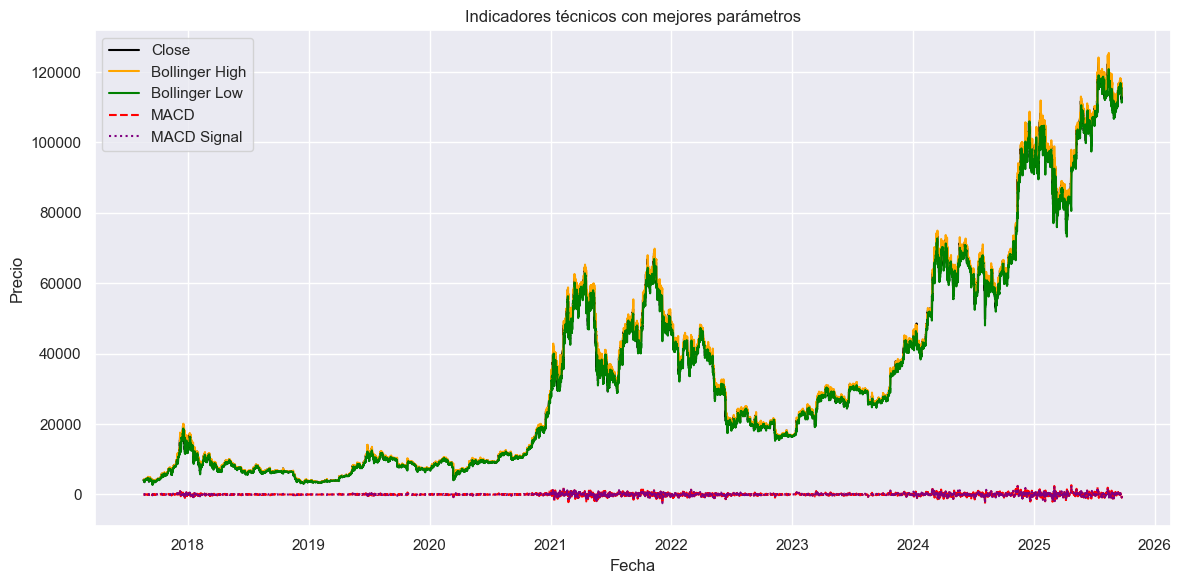

In [207]:
params = study.best_params
df_plot = data.copy()

df_plot['rsi'] = ta.momentum.RSIIndicator(df_plot['Close'], window=params['rsi_window']).rsi()
macd = ta.trend.MACD(df_plot['Close'], window_slow=params['macd_slow'],
                     window_fast=params['macd_fast'], window_sign=params['macd_signal'])
df_plot['macd'] = macd.macd()
df_plot['macd_signal'] = macd.macd_signal()
bb = ta.volatility.BollingerBands(df_plot['Close'], window=params['bb_window'], window_dev=params['bb_dev'])
df_plot['bb_low'] = bb.bollinger_lband()
df_plot['bb_high'] = bb.bollinger_hband()

df_plot = df_plot.dropna()

df_zoom = df_plot.iloc[-100000:]

plt.figure(figsize=(12, 6))
plt.plot(df_zoom['Close'], label="Close", color='black')
plt.plot(df_zoom['bb_high'], label="Bollinger High", color='orange')
plt.plot(df_zoom['bb_low'], label="Bollinger Low", color='green')
plt.plot(df_zoom['macd'], label="MACD", color='red', linestyle='--')
plt.plot(df_zoom['macd_signal'], label="MACD Signal", color='purple', linestyle=':')
plt.title("Indicadores técnicos con mejores parámetros")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Gráfica 2. Valor del portafolio a lo largo del tiempo con los mejores parámetros

[I 2025-10-04 12:54:23,108] A new study created in memory with name: no-name-b27f347d-e9ad-454b-bb6b-358d835b4626


[I 2025-10-04 12:54:24,843] Trial 0 finished with value: 0.06707397102718426 and parameters: {'rsi_window': 22, 'rsi_buy': 22, 'rsi_sell': 87, 'macd_fast': 7, 'macd_slow': 25, 'macd_signal': 15, 'bb_window': 21, 'bb_dev': 1.7673095851020553, 'stop_loss': 0.03079454086648022, 'take_profit': 0.04744302101300035, 'n_shares': 1.663223320483355}. Best is trial 0 with value: 0.06707397102718426.
[I 2025-10-04 12:54:26,638] Trial 1 finished with value: -0.2812551793440606 and parameters: {'rsi_window': 22, 'rsi_buy': 20, 'rsi_sell': 73, 'macd_fast': 7, 'macd_slow': 40, 'macd_signal': 11, 'bb_window': 20, 'bb_dev': 1.9655286488469048, 'stop_loss': 0.04992125706762733, 'take_profit': 0.14378691821354309, 'n_shares': 1.9106654638027682}. Best is trial 0 with value: 0.06707397102718426.
[I 2025-10-04 12:54:28,398] Trial 2 finished with value: 0.10295341230162397 and parameters: {'rsi_window': 23, 'rsi_buy': 11, 'rsi_sell': 73, 'macd_fast': 15, 'macd_slow': 38, 'macd_signal': 15, 'bb_window': 22, 

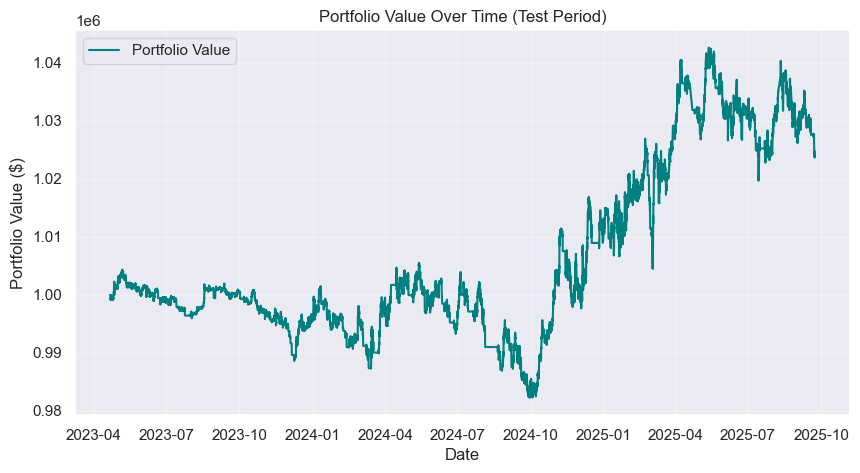

In [208]:
# ===== Backtest function =====
def backtest(params, df_in, wf_split=0.7, plot=False):
    """
    Walk-forward backtest with long/short and signal confirmation (2/3 indicators)
    Returns Calmar Ratio and optionally plots portfolio evolution
    """

    # ===== Unpack parameters =====
    rsi_window = int(params['rsi_window'])
    rsi_buy = float(params['rsi_buy'])
    rsi_sell = float(params['rsi_sell'])
    macd_fast = int(params['macd_fast'])
    macd_slow = int(params['macd_slow'])
    macd_signal = int(params['macd_signal'])
    bb_window = int(params['bb_window'])
    bb_dev = float(params['bb_dev'])
    stop_loss = float(params['stop_loss'])
    take_profit = float(params['take_profit'])
    n_shares = params['n_shares']

    # ===== Split for Walk-Forward =====
    split_idx = int(len(df_in) * wf_split)
    train_df = df_in.iloc[:split_idx].copy()
    test_df = df_in.iloc[split_idx:].copy()

    # ===== Backtest Engine =====
    def run_backtest(df):
        # --- Indicators ---
        df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=rsi_window).rsi()
        macd = ta.trend.MACD(df['Close'], window_slow=macd_slow,
                             window_fast=macd_fast, window_sign=macd_signal)
        df['macd'] = macd.macd()
        df['macd_signal'] = macd.macd_signal()
        bb = ta.volatility.BollingerBands(df['Close'], window=bb_window, window_dev=bb_dev)
        df['bb_low'] = bb.bollinger_lband()
        df['bb_high'] = bb.bollinger_hband()
        df = df.dropna()

        # --- Signals (2 of 3 confirmation) ---
        rsi_buy_sig = df['rsi'] < rsi_buy
        rsi_sell_sig = df['rsi'] > rsi_sell
        macd_long_sig = df['macd'] > df['macd_signal']
        macd_short_sig = df['macd'] < df['macd_signal']
        bb_long_sig = df['Close'] < df['bb_low']
        bb_short_sig = df['Close'] > df['bb_high']

        df['long_signal'] = ((rsi_buy_sig.astype(int) +
                              macd_long_sig.astype(int) +
                              bb_long_sig.astype(int)) >= 2)
        df['short_signal'] = ((rsi_sell_sig.astype(int) +
                               macd_short_sig.astype(int) +
                               bb_short_sig.astype(int)) >= 2)

        # --- Backtesting parameters ---
        T_fee = 0.125 / 100.0
        cash = 1_000_000.0
        active_positions = []
        portfolio_values = []

        class Position:
            def __init__(self, price, n_shares, sl, tp, pos_type):
                self.price = price
                self.n_shares = n_shares
                self.sl = sl
                self.tp = tp
                self.pos_type = pos_type  # 'long' or 'short'

        # --- Simulation Loop ---
        for idx, row in df.iterrows():
            # Check active positions
            for pos in active_positions.copy():
                if pos.pos_type == 'long':
                    if (row['Close'] >= pos.tp) or (row['Close'] <= pos.sl) or row['short_signal']:
                        cash += row['Close'] * pos.n_shares * (1 - T_fee)
                        active_positions.remove(pos)
                elif pos.pos_type == 'short':
                    if (row['Close'] <= pos.tp) or (row['Close'] >= pos.sl) or row['long_signal']:
                        cash += (2*pos.price - row['Close']) * pos.n_shares * (1 - T_fee)
                        active_positions.remove(pos)

            # Open new positions
            if row['long_signal'] and all(p.pos_type != 'long' for p in active_positions):
                cost = row['Close'] * n_shares * (1 + T_fee)
                if cash >= cost:
                    cash -= cost
                    active_positions.append(Position(
                        row['Close'], n_shares,
                        sl=row['Close'] * (1 - stop_loss),
                        tp=row['Close'] * (1 + take_profit),
                        pos_type='long'))

            if row['short_signal'] and all(p.pos_type != 'short' for p in active_positions):
                cost = row['Close'] * n_shares * (1 + T_fee)
                if cash >= cost:
                    cash -= cost
                    active_positions.append(Position(
                        row['Close'], n_shares,
                        sl=row['Close'] * (1 + stop_loss),
                        tp=row['Close'] * (1 - take_profit),
                        pos_type='short'))

            # Track total portfolio value
            portfolio_value = cash
            for pos in active_positions:
                if pos.pos_type == 'long':
                    portfolio_value += pos.n_shares * row['Close']
                else:
                    portfolio_value += pos.n_shares * (2*pos.price - row['Close'])
            portfolio_values.append((idx, portfolio_value))

        # Close remaining positions
        if active_positions:
            last_close = df.iloc[-1]['Close']
            for pos in active_positions:
                if pos.pos_type == 'long':
                    cash += last_close * pos.n_shares * (1 - T_fee)
                else:
                    cash += (2*pos.price - last_close) * pos.n_shares * (1 - T_fee)
            portfolio_values[-1] = (portfolio_values[-1][0], cash)

        # Convert portfolio history to Series
        idxs, vals = zip(*portfolio_values)
        port_ser = pd.Series(vals, index=pd.DatetimeIndex(idxs)).sort_index()

        # --- Calmar Ratio ---
        peak = port_ser.cummax()
        drawdown = (port_ser - peak) / peak
        max_drawdown = drawdown.min()

        start_date = port_ser.index[0]
        end_date = port_ser.index[-1]
        n_years = (end_date - start_date).days / 365.25
        if n_years <= 0:
            return -1e6, port_ser
        cagr = (port_ser.iloc[-1] / port_ser.iloc[0])**(1 / n_years) - 1
        calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else 0

        return calmar_ratio, port_ser

    # Run walk-forward
    train_ratio, _ = run_backtest(train_df)
    test_ratio, test_portfolio = run_backtest(test_df)

    # Penalize overfitting
    if train_ratio > 0 and test_ratio / train_ratio < 0.5:
        test_ratio *= 0.5

    # Optional plotting
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(test_portfolio.index, test_portfolio.values, label='Portfolio Value', color='teal')
        plt.title("Portfolio Value Over Time (Test Period)")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value ($)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    return test_ratio, test_portfolio

def objective(trial):
    params = {
        'rsi_window': trial.suggest_int('rsi_window', 5, 30),
        'rsi_buy': trial.suggest_int('rsi_buy', 5, 30),
        'rsi_sell': trial.suggest_int('rsi_sell', 70, 95),
        'macd_fast': trial.suggest_int('macd_fast', 5, 15),
        'macd_slow': trial.suggest_int('macd_slow', 20, 40),
        'macd_signal': trial.suggest_int('macd_signal', 5, 15),
        'bb_window': trial.suggest_int('bb_window', 10, 30),
        'bb_dev': trial.suggest_float('bb_dev', 1.5, 3.0),
        'stop_loss': trial.suggest_float('stop_loss', 0.01, 0.1),
        'take_profit': trial.suggest_float('take_profit', 0.01, 0.2),
        'n_shares': trial.suggest_float('n_shares', 0.1, 4)
    }
    result, _ = backtest(params, df_in=data)
    return result

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# ===== Plot Portfolio for Best Parameters =====
_, best_portfolio = backtest(study.best_params, df_in=data, plot=True)

